Fitted Parameters:
R = 780.00 Ω
L = 1.31e-13 H
C = 3.63e-09 F
Resonance frequency: 7.2973 GHz


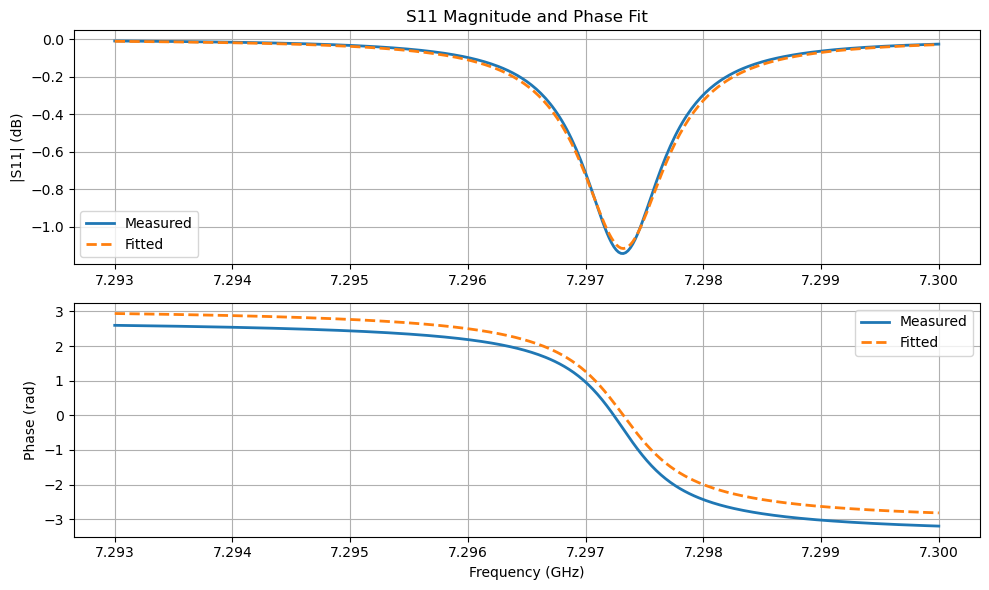

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants
Z0 = 50  # Characteristic impedance (Ohms)

# === 1. Load the CSV data ===
# Replace 's11_data.csv' with your actual file path
csv_path = "/home/lesnow/PalaceForCQED/examples/data_v8/readout_resonator/lumped_7.293-7.3_Step2.0e-5_2025-05-09T125905/port-S.csv"
data = pd.read_csv(csv_path, comment='#', header=None, skiprows=1)
data.columns = ['Freq_GHz', 'S11_dB', 'S11_phase_deg']

# Filter data to keep only frequencies between 7.29 and 7.31 GHz
mask = (data['Freq_GHz'] >= 7.294) & (data['Freq_GHz'] <= 7.299)
# data = data[mask]

# Convert to numpy arrays
f = data['Freq_GHz'].values * 1.0e9  # Convert GHz to Hz

S11_mag_dB = data['S11_dB'].values
S11_phase_deg = data['S11_phase_deg'].values

# === 2. Convert dB and phase to complex S11 ===
S11_mag = 10**(S11_mag_dB / 20)
S11_phase_rad = np.unwrap(np.deg2rad(S11_phase_deg)) + np.pi  # Unwrap phase and shift by pi
S11_complex = S11_mag * np.exp(1j * S11_phase_rad)

# === 3. Define the model function for S11 of a shunt RLC ===
# Initial guess: R (Ohm), L (H), C (F)
# Use reasonable initial guess near resonance
f0 = f[np.argmin(np.abs(S11_mag))]  # Find resonance frequency
L0 = 1e-13
C0 = 1 / ((2 * np.pi * f0)**2 * L0)  # 4.75e-10
R0 = 780  # Ohm

def s11_shunt_RLC(f, L):
    C= 1 / ((2 * np.pi * f0)**2 * L)  # Capacitance from frequency
    omega = 2 * np.pi * f
    Y = 1/R0 + 1j*omega*C - 1j/(omega*L)
    Zin = 1 / Y
    S11 = (Zin - Z0) / (Zin + Z0)
    return np.concatenate([np.real(S11), np.imag(S11)])

# === 4. Prepare data for curve fitting ===
# Stack real and imaginary parts for complex fitting
S11_fit_target = np.concatenate([np.real(S11_complex), np.imag(S11_complex)])

initial_guess = [L0]

# === 5. Perform the curve fitting ===
popt, pcov = curve_fit(s11_shunt_RLC, f, S11_fit_target, p0=initial_guess, method="lm")
# popt, pcov = curve_fit(s11_shunt_RLC, f, S11_fit_target, p0=initial_guess, method="lm")

# Extract fitted parameters
L_fit = L0
R_fit = R0
L_fit = popt[0]
C_fit = 1 / ((2 * np.pi * f0)**2 * L_fit)  # Capacitance from frequency
print(f"Fitted Parameters:\nR = {R_fit:.2f} Ω\nL = {L_fit:.2e} H\nC = {C_fit:.2e} F")
print(f"Resonance frequency: {1/(2*np.pi*np.sqrt(L_fit*C_fit))/1e9:.4f} GHz")

# === 6. Plotting ===
# Generate fitted S11
# S11_fit_complex = s11_shunt_RLC(f, L_fit, R_fit)
S11_fit_complex = s11_shunt_RLC(f, *popt)
S11_fit_complex = S11_fit_complex[:len(f)] + 1j * S11_fit_complex[len(f):]

# Convert to dB and phase
S11_fit_dB = 20 * np.log10(np.abs(S11_fit_complex))
S11_fit_phase_rad = np.angle(S11_fit_complex)

# Plot magnitude
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(f / 1e9, S11_mag_dB, label='Measured', linewidth=2)
plt.plot(f / 1e9, S11_fit_dB, '--', label='Fitted', linewidth=2)
plt.ylabel('|S11| (dB)')
plt.title('S11 Magnitude and Phase Fit')
plt.grid(True)
plt.legend()

# Plot phase
plt.subplot(2, 1, 2)
plt.plot(f / 1e9, S11_phase_rad, label='Measured', linewidth=2)
plt.plot(f / 1e9, S11_fit_phase_rad, '--', label='Fitted', linewidth=2)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Phase (rad)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Equivalent Circuit Parameters Fitting for Resonator S-Parameters

This notebook fits S-parameter data from a resonator to an equivalent RLC circuit model. The main improvements include:

1. **Parameter normalization**: Scaling parameters to similar orders of magnitude to improve numerical stability of the fitting algorithm
2. **Frequency normalization**: Normalizing frequency values to the [0,1] range
3. **Bounded optimization**: Setting reasonable constraints on parameter values
4. **Trust-region reflective method**: Using a more robust optimization algorithm
5. **Quality factor calculation**: Computing the resonator's quality factor
6. **Complex plane visualization**: Adding a Smith chart-like plot in the complex plane

The shunt RLC circuit model has the following components in parallel:
- R: Resistance (Ω)
- L: Inductance (H)
- C: Capacitance (F)